In [ ]:
"""Main training loop. Fine-tune the whole model"""

import os
import csv
import time
import copy
import json
import pickle
import random
import dnnlib
import numpy as np
import torch
from torch import autocast
from torch_utils import distributed as dist
from torch_utils import training_stats
from torch_utils import misc
from solver_utils import get_schedule
from models.ldm.util import instantiate_from_config
from torch_utils.download_util import check_file_by_key
import torchvision.utils as vutils

from torch.utils.tensorboard import SummaryWriter
import glob
#----------------------------------------------------------------------------
# Load pre-trained models from the LDM codebase (https://github.com/CompVis/latent-diffusion) 
# and Stable Diffusion codebase (https://github.com/CompVis/stable-diffusion)

def load_ldm_model(config, ckpt, verbose=False, repeat=1):
    from models.ldm.util import instantiate_from_config
    
    if ckpt.endswith("ckpt"):
        pl_sd = torch.load(ckpt, map_location="cpu", weights_only=False)
        if "global_step" in pl_sd:
            dist.print0(f"Global Step: {pl_sd['global_step']}")
        sd = pl_sd["state_dict"]
    else:
        raise NotImplementedError
    
    config.model.params.unet_config.repeat = repeat
    model = instantiate_from_config(config.model)
    
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)
    return model

#----------------------------------------------------------------------------

def create_model(dataset_name=None, model_path=None, guidance_type=None, guidance_rate=None, device=None, is_second_stage=False, num_repeats=1):
    print("Function Parameters:")
    for key, value in locals().items():
        print(f"{key}: {value}")

    net_student = None
    if is_second_stage: # for second-stage distillation
        assert model_path is not None
        dist.print0(f'Loading the second-stage teacher model from "{model_path}"...')
        with dnnlib.util.open_url(model_path, verbose=(dist.get_rank() == 0)) as f:
            net = pickle.load(f)['model'].to(device)
        model_source = 'edm' if dataset_name in ['cifar10', 'ffhq', 'afhqv2', 'imagenet64'] else 'ldm'
        return net, model_source

    if model_path is None:
        model_path, _ = check_file_by_key(dataset_name)
    dist.print0(f'Loading the pre-trained diffusion model from "{model_path}"...')
    if dataset_name in ['cifar10', 'ffhq', 'afhqv2', 'imagenet64']:         # models from EDM
        with dnnlib.util.open_url(model_path, verbose=(dist.get_rank() == 0)) as f:
            net_temp = pickle.load(f)['ema'].to(device)
        network_kwargs = dnnlib.EasyDict()
        if dataset_name in ['cifar10']:
            network_kwargs.update(model_type='SongUNet', embedding_type='positional', encoder_type='standard', decoder_type='standard')
            network_kwargs.update(channel_mult_noise=1, resample_filter=[1,1], model_channels=128, channel_mult=[2,2,2])
            network_kwargs.update(dropout=0.13, use_fp16=False)
            network_kwargs.augment_dim = 9
            interface_kwargs = dict(img_resolution=32, img_channels=3, label_dim=0)
        elif dataset_name in ['ffhq', 'afhqv2']:
            network_kwargs.update(model_type='SongUNet', embedding_type='positional', encoder_type='standard', decoder_type='standard')
            network_kwargs.update(channel_mult_noise=1, resample_filter=[1,1], model_channels=128, channel_mult=[1,2,2,2])
            network_kwargs.update(dropout=0.05, use_fp16=False)
            network_kwargs.augment_dim = 9
            interface_kwargs = dict(img_resolution=64, img_channels=3, label_dim=0)
        else:
            network_kwargs.update(model_type='DhariwalUNet', model_channels=192, channel_mult=[1,2,3,4])
            interface_kwargs = dict(img_resolution=64, img_channels=3, label_dim=1000)
        network_kwargs.class_name = 'models.networks_edm.EDMPrecond'
        net = dnnlib.util.construct_class_by_name(**network_kwargs, **interface_kwargs) # subclass of torch.nn.Module
        net.to(device)
        net.load_state_dict(net_temp.state_dict(), strict=False)

        network_kwargs.update(repeat=num_repeats)
        net_student = dnnlib.util.construct_class_by_name(**network_kwargs, **interface_kwargs)
        net_student.to(device)
        net_student.load_state_dict(net_temp.state_dict(), strict=False)

        del net_temp

        net.sigma_min = 0.006
        net.sigma_max = 80.0
        net_student.sigma_min = 0.006
        net_student.sigma_max = 80.0
        model_source = 'edm'
    elif dataset_name in ['lsun_bedroom_ldm', 'ffhq_ldm', 'ms_coco']:   # models from LDM
        from omegaconf import OmegaConf
        from models.networks_edm import CFGPrecond
        if dataset_name in ['lsun_bedroom_ldm']:
            assert guidance_type == 'uncond'
            config = OmegaConf.load('./models/ldm/configs/latent-diffusion/lsun_bedrooms-ldm-vq-4.yaml')
            net = load_ldm_model(config, model_path)
            net = CFGPrecond(net, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            net.sigma_min = 0.006

            net_student = load_ldm_model(config, model_path, repeat=num_repeats)
            net = CFGPrecond(net_student, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            net_student.sigma_min = 0.006

        elif dataset_name in ['ffhq_ldm']:
            assert guidance_type == 'uncond'
            config = OmegaConf.load('./models/ldm/configs/latent-diffusion/ffhq-ldm-vq-4.yaml')
            net = load_ldm_model(config, model_path)
            net = CFGPrecond(net, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            net.sigma_min = 0.006

            net_student = load_ldm_model(config, model_path, repeat=num_repeats)
            net_student = CFGPrecond(net, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            net_student.sigma_min = 0.006

        elif dataset_name in ['ms_coco']:
            assert guidance_type == 'cfg'
            config = OmegaConf.load('./models/ldm/configs/stable-diffusion/v1-inference.yaml')
            net = load_ldm_model(config, model_path)
            net = CFGPrecond(net, img_resolution=64, img_channels=4, guidance_rate=guidance_rate, guidance_type='classifier-free', label_dim=True).to(device)
            net.sigma_min = 0.1

            net_student = load_ldm_model(config, model_path)
            net_student = CFGPrecond(net, img_resolution=64, img_channels=4, guidance_rate=guidance_rate, guidance_type='classifier-free', label_dim=True).to(device)
            net_student.sigma_min = 0.1

        model_source = 'ldm'
    else:
        raise ValueError(f"Unsupported dataset_name: {dataset_name}")
    
    return net, net_student, model_source

#----------------------------------------------------------------------------
# Check model structure

def print_network_layers(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Module):
            dist.print0(name)

#----------------------------------------------------------------------------

class RandomIntGenerator:
    def __init__(self, seed=42):
        random.seed(seed)

    def randint(self, int_min, int_max):
        while True:
            yield random.randint(int_min, int_max)

#----------------------------------------------------------------------------

def training_loop(
    run_dir             = '.',      # Output directory.
    loss_kwargs         = {},       # Options for loss function.
    optimizer_kwargs    = {},       # Options for optimizer.
    seed                = 0,        # Global random seed.
    batch_size          = None,     # Total batch size for one training iteration.
    batch_gpu           = None,     # Limit batch size per GPU, None = no limit.
    total_kimg          = 20,       # Training duration, measured in thousands of training images.
    kimg_per_tick       = 1,        # Interval of progress prints.
    snapshot_ticks      = 1,        # How often to save network snapshots, None = disable.
    state_dump_ticks    = 99,       # How often to dump training state, None = disable.
    cudnn_benchmark     = True,     # Enable torch.backends.cudnn.benchmark?
    dataset_name        = None,
    model_path          = None,
    guidance_type       = None,
    guidance_rate       = 0.,
    device              = torch.device('cuda'),
    is_second_stage     = False,
    weight_ls = [1, 1, 1, 1], 
    **kwargs,
):
    # writer = SummaryWriter('') if dist.get_rank() == 0 else None
    writer = SummaryWriter(run_dir) if dist.get_rank() == 0 else None
    print(run_dir)

    start_time = time.time()
    np.random.seed((seed * dist.get_world_size() + dist.get_rank()) % (1 << 31))
    torch.manual_seed(np.random.randint(1 << 31))

    torch.backends.cudnn.benchmark = cudnn_benchmark
    torch.backends.cudnn.allow_tf32 = False
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = False

    batch_gpu_total = batch_size // dist.get_world_size()
    if batch_gpu is None or batch_gpu > batch_gpu_total:
        batch_gpu = batch_gpu_total
    num_acc_rounds = batch_gpu_total // batch_gpu
    assert batch_size == batch_gpu * num_acc_rounds * dist.get_world_size()
   
    if dataset_name in ['ms_coco']:
        prompt_path, _ = check_file_by_key('prompts')
        sample_captions = []
        with open(prompt_path, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                sample_captions.append(row['text'])

    if dist.get_rank() != 0:
        torch.distributed.barrier()

    print(kwargs)
    if loss_kwargs["use_repeats"]:
        net_copy, net, model_source = create_model(dataset_name, model_path, guidance_type, guidance_rate, device, is_second_stage, num_repeats=loss_kwargs["M"]+1)
    else:
        net_copy, net, model_source = create_model(dataset_name, model_path, guidance_type, guidance_rate, device, is_second_stage, num_repeats=1)
    np.random.seed((seed * dist.get_world_size() + dist.get_rank()) % (1 << 31))
    torch.manual_seed(np.random.randint(1 << 31))

    if dataset_name in ['ms_coco']:
        net.guidance_rate = 1.0
    net.use_fp16 = True
    net_copy.eval().requires_grad_(False) # CP: Original code did not set requires_grad to False, but it is better to do so.
                                          # Shree: bro thats coz it was set inside model creation by default
                                          # Tushar: Aapne banaya tha.?!

    net_copy.use_fp16 = True
    net.train().requires_grad_(True)

    if dist.get_rank() == 0:
        torch.distributed.barrier()

    total_params_unet = sum(p.numel() for p in net.parameters())
    dist.print0("Total parameters in U-Net:     ", total_params_unet)
    

    # Setup optimizer.
    dist.print0('Setting up optimizer...')
    loss_kwargs.update(sigma_min=net.sigma_min, sigma_max=net.sigma_max, model_source=model_source)
    loss_fn = dnnlib.util.construct_class_by_name(**loss_kwargs)
    optimizer = dnnlib.util.construct_class_by_name(params=net.parameters(), **optimizer_kwargs)

    net.training_kwargs = loss_kwargs
    net.training_kwargs['dataset_name'] = dataset_name
    net.training_kwargs['guidance_type'] = guidance_type
    net.training_kwargs['guidance_rate'] = guidance_rate

    ddp = torch.nn.parallel.DistributedDataParallel(net, device_ids=[device], broadcast_buffers=False, find_unused_parameters=True)

    dist.print0(f'Training for {total_kimg} kimg...')
    cur_nimg = 0
    cur_tick = 0
    tick_start_nimg = cur_nimg
    tick_start_time = time.time()
    maintenance_time = tick_start_time - start_time
    dist.update_progress(cur_nimg // 1000, total_kimg)
    stats_jsonl = None
    rig = RandomIntGenerator()
    num_acc_rounds = 128 // batch_size if dataset_name == 'ms_coco' else 1
    batch_gpu_total = num_acc_rounds * batch_gpu

    # Initialize best_loss to a very high number.
    best_loss = float('inf')
    
    # Store initial weight_ls for interpolation
    initial_weight_ls = weight_ls.copy()
    target_weight_ls = [0, 0, 0, 1]
    
    if guidance_type == 'cfg' and dataset_name in ['ms_coco']:
        with torch.no_grad():
            uc = net.model.get_learned_conditioning(batch_gpu * [""])
    loss = torch.zeros(1,)
    to_save = 0
    while True:
        if torch.isnan(loss).any().item():
            net.use_fp16 = False 
            net_copy.use_fp16 = False 
            dist.print0('Meet nan, disable fp16!')

        if loss_fn.use_step_condition and not loss_fn.is_second_stage:
            print("Using step condition")
            loss_fn.num_steps = next(rig.randint(4, 7))
            print("Number of steps for this iteration:", loss_fn.num_steps)
            loss_fn.M = 2 if loss_fn.num_steps == 3 else 3
            loss_fn.t_steps = get_schedule(loss_fn.num_steps, loss_fn.sigma_min, loss_fn.sigma_max, schedule_type=loss_fn.schedule_type, schedule_rho=loss_fn.schedule_rho, device=device, net=net_copy)
            loss_fn.num_steps_teacher = (loss_fn.M + 1) * (loss_fn.num_steps - 1) + 1
            loss_fn.tea_slice = [i * (loss_fn.M + 1) for i in range(1, loss_fn.num_steps)]

        # Generate latents and conditions in every first step
        latents = [loss_fn.sigma_max * torch.randn([batch_gpu, net.img_channels, net.img_resolution, net.img_resolution], device=device) for k in range(num_acc_rounds)]
        labels = [None for k in range(num_acc_rounds)]
        if net.label_dim:
            if guidance_type == 'cfg' and dataset_name in ['ms_coco']:      # For Stable Diffusion
                prompts = [random.sample(sample_captions, batch_gpu) for k in range(num_acc_rounds)]
                with torch.no_grad():
                    if isinstance(prompts[0], tuple):
                        prompts = [list(p) for p in prompts]
                    c = [net.model.get_learned_conditioning(prompts[k]) for k in range(num_acc_rounds)]
            else:                                                           # EDM models
                labels = [torch.eye(net.label_dim, device=device)[torch.randint(net.label_dim, size=[batch_gpu], device=device)] for k in range(num_acc_rounds)]
                
        with torch.no_grad():
            if guidance_type in ['uncond', 'cfg']:      # LDM and SD models
                with autocast("cuda"):
                    with net_copy.model.ema_scope():
                        teacher_traj = [loss_fn.get_teacher_traj(net=net_copy, tensor_in=latents[k], labels=labels[k], condition=c[k], unconditional_condition=uc) for k in range(num_acc_rounds)]
            else:
                teacher_traj = [loss_fn.get_teacher_traj(net=net_copy, tensor_in=latents[k], labels=labels[k]) for k in range(num_acc_rounds)]
                # print("Shape of the teacher trajectory:", teacher_traj[0].shape) # shape is (total_steps, batch_size, channels, height, width)
        # Calculate discrete weight updates every 1000 images within kimg_per_tick
        images_in_tick = cur_nimg - tick_start_nimg
        max_images_in_tick = kimg_per_tick * 1000
        
        steps_completed = images_in_tick // 1000
        total_steps_in_tick = max_images_in_tick // 1000
        
        if total_steps_in_tick > 0:
            progress_discrete = min(steps_completed / total_steps_in_tick, 1.0)
        else:
            progress_discrete = 0.0
                # Total images processed so far
        total_images_processed = cur_nimg  

        # Total images for the entire training
        total_images = total_kimg * 1000  # convert kimg to images

        # Compute overall discrete progress across the whole training
        steps_completed = total_images_processed // 1000
        total_steps = total_images // 1000

        if total_steps > 0:
            progress_discrete = min(steps_completed / total_steps, 1.0)
        else:
            progress_discrete = 0.0

        current_weight_ls = []
        for i in range(len(initial_weight_ls)):
            interpolated_weight = initial_weight_ls[i] + progress_discrete * (target_weight_ls[i] - initial_weight_ls[i])
            current_weight_ls.append(interpolated_weight)
        # Print weight updates every 1000 images
        if cur_nimg % 1000 == 0:
            dist.print0(f"Weight update - Step: {steps_completed}/{total_steps_in_tick}, Progress: {progress_discrete:.3f}, Current weights: {[f'{w:.3f}' for w in current_weight_ls]}, Images: {cur_nimg}")

        student_traj = []
        for step_idx in range(loss_fn.num_steps - 1):
            # if step_idx in [1, 2]:
            #     continue
            start = step_idx * (loss_fn.M + 1) + 1
            end = start + (loss_fn.M + 1)

            optimizer.zero_grad(set_to_none=True)

            # Calculate loss
            # weight_ls = [0.1,0.1,0.1,1]
            print("current step ", step_idx, " weight_ls: ", current_weight_ls)
            for round_idx in range(num_acc_rounds):
                print(f"round {round_idx}")
                with misc.ddp_sync(ddp, (round_idx == num_acc_rounds - 1)):
                    if guidance_type in ['uncond', 'cfg']:
                        with autocast("cuda"):
                            # loss, stu_out = loss_fn(net=ddp, tensor_in=latents[round_idx], labels=labels[round_idx], step_idx=step_idx, teacher_out=teacher_traj[round_idx][step_idx], condition=c[round_idx], unconditional_condition=uc)
                            loss, stu_out, loss_ls, stu_out_comp , loss_for_logging= loss_fn(
                                net=ddp, 
                                tensor_in=latents[round_idx], 
                                labels=labels[round_idx], 
                                step_idx=step_idx, 
                                teacher_out=teacher_traj[round_idx][start:end], 
                                condition=c[round_idx], 
                                unconditional_condition=uc,
                                weight_ls = weight_ls)
                    else:
                        loss, stu_out, loss_ls, stu_out_comp, loss_for_logging = loss_fn(
                            net=ddp,
                            tensor_in=latents[round_idx],
                            labels=labels[round_idx],
                            step_idx=step_idx,
                            teacher_out=teacher_traj[round_idx][start:end],
                            weight_ls = weight_ls
                    
                        ) # NOTE : Loss here is that weighted loss that big ass normalisation formula and the 
                    # print("Shape of stu_out_comp: ", stu_out_comp.shape)
                    student_traj.append(stu_out_comp[:4,:,:,:])
                    latents[round_idx] = stu_out
                    training_stats.report('Loss/loss', loss)

                    # writer.add_scalar('Loss/loss', loss.item(), cur_nimg // 1000)

                    if not (loss_fn.afs and step_idx == 0):
                        loss.sum().mul(1 / batch_gpu_total).backward()
            
            with torch.no_grad():  
                loss_norm = torch.norm(loss_for_logging, p=2, dim=(1,2,3))
                loss_mean, loss_std = loss_norm.mean().item(), loss_norm.std().item()
            dist.print0("Step: {} | Loss-mean: {:12.8f} | loss-std: {:12.8f}".format(step_idx, loss_mean, loss_std))
            writer.add_scalar('Loss/loss_total', loss_mean, cur_nimg // 1000)
            loss_ls_norm = []

            for i in range(len(loss_ls)):
                loss_ls_norm.append(loss_ls[i].norm(p=2, dim=(1,2,3)))
                dist.print0("Step: {} | Loss_ls-{}-mean: {:12.8f} | loss_ls-{}-std: {:12.8f}".format(step_idx, i, loss_ls_norm[i].mean().item(), i, loss_ls_norm[i].std().item()))
                if step_idx == loss_fn.M-1 and i ==len(loss_ls)-1:
                    final_loss = loss_ls_norm[i].mean().item()

                writer.add_scalar(f'Loss/loss_ls_{i}', loss_ls_norm[i].mean().item(), cur_nimg // 1000)
            if step_idx == loss_fn.num_steps - 2:
                final_loss = loss_mean
            if not (loss_fn.afs and step_idx == 0):
                for param in net.parameters():
                    if param.grad is not None:
                        torch.nan_to_num(param.grad, nan=0, posinf=1e5, neginf=-1e5, out=param.grad)
                optimizer.step()
                
        to_save += 1

        # if(cur_tick % 10 == 0):
        #     for round_idx in range(num_acc_rounds):    
        #         # generating the image at each step of the teacher trajectory first 8 images of batch
        #         traj = teacher_traj[0][:,:8,:,:,:] 
        #         # print("Shape of traj ", traj.shape)
        #         total_steps, batch_size_temp = traj.shape[0], traj.shape[1]

        #         all_images = traj.contiguous().view(total_steps * batch_size_temp, traj.shape[2], traj.shape[3], traj.shape[4])
        #         if model_source == 'edm':
        #             all_images = torch.clamp((all_images + 1) / 2, min=0, max=1)
        #         elif model_source == 'ldm':
        #             all_images = torch.clamp(all_images, min=0, max=1)

        #         grid = vutils.make_grid(
        #             all_images,
        #             nrow=8,
        #             normalize=False,
        #             padding = 2,
        #             pad_value=1.0
        #         )
        #         # size of the grid
        #         # print("Shape of the grid: ", grid.shape)
        #         vutils.save_image(grid, os.path.join(run_dir, f'teacher_traj_{cur_tick}.png'))
        #         print(f"Saved teacher trajectory images to {os.path.join(run_dir, f'teacher_traj_{cur_tick}.png')}")
        #         # Tensorboard on lightning is not displaying the images properly for some reason
        #         if writer is not None:
        #             writer.add_image(
        #                 f'Some shit_{cur_tick}',
        #                 grid,
        #                 global_step=cur_nimg // 1000,
        #             )
        #             writer.flush()
        #             print(f"Added teacher trajectory images to TensorBoard at step {cur_nimg // 1000}.")

        #     all_student_images = []

        #     for idx, traj_student in enumerate(student_traj):
        #         traj_student = traj_student[:, :8, :, :, :]  # Shape: (total_steps, 8, channels, height, width)
        #         # print(f"Shape of traj_student[{idx}]: ", traj_student.shape)

        #         total_steps, batch_size_temp = traj_student.shape[0], traj_student.shape[1]
        #         images_student = traj_student.contiguous().view(
        #             total_steps * batch_size_temp, traj_student.shape[2], traj_student.shape[3], traj_student.shape[4]
        #         )

        #         # Normalize images for plotting
        #         if model_source == 'edm':
        #             images_student = torch.clamp((images_student + 1) / 2, min=0, max=1)
        #         elif model_source == 'ldm':
        #             images_student = torch.clamp(images_student, min=0, max=1)

        #         all_student_images.append(images_student)

        #     all_student_images = torch.cat(all_student_images, dim=0)

        #     grid_all_students = vutils.make_grid(
        #         all_student_images,
        #         nrow=8,  
        #         normalize=False,
        #         padding=2,
        #         pad_value=1.0
        #     )

        #     vutils.save_image(grid_all_students, os.path.join(run_dir, f'student_traj_combined_{cur_tick}.png'))
        #     print(f"Saved combined student trajectory images to {os.path.join(run_dir, f'student_traj_combined_{cur_tick}.png')}")


        if cur_nimg / 1000 >= 0.5 * total_kimg:
            for g in optimizer.param_groups:
                g['lr'] = optimizer_kwargs['lr'] / 10

        cur_nimg += batch_size * num_acc_rounds
        done = (cur_nimg >= total_kimg * 1000)
        # if to_save % 10 == 0:
        #     if dist.get_rank() == 0:  # Only save from main process
        #         data = dict(model=net)
        #         for key, value in data.items():
        #             if isinstance(value, torch.nn.Module):
        #                 value = copy.deepcopy(value).eval().requires_grad_(False)
        #                 misc.check_ddp_consistency(value)
        #                 data[key] = value.cpu()
        #             del value

        #         snapshot_filename = f'network-snapshot-{to_save}.pkl'
        #         snapshot_path = os.path.join(run_dir, snapshot_filename)
        #         with open(snapshot_path, 'wb') as f:
        #             pickle.dump(data, f)
        #         dist.print0(f"Saved periodic snapshot: {snapshot_filename}")

        #         del data  # conserve memory
        # if (cur_tick != 0) and (final_loss < best_loss):
        #     best_loss = final_loss
            
        #     # Only the main process (rank 0) handles file operations
        #     if dist.get_rank() == 0:
        #         # Delete the previous snapshot file if it exists
        #         snapshot_pattern = os.path.join(run_dir, 'network-snapshot-*.pkl')
        #         prev_files = glob.glob(snapshot_pattern)
        #         for prev_file in prev_files:
        #             try:
        #                 os.remove(prev_file)
        #                 dist.print0(f"Removed previous snapshot: {prev_file}")
        #             except (FileNotFoundError, PermissionError, OSError) as e:
        #                 dist.print0(f"Warning: Could not remove {prev_file}: {e}")

        #     # Prepare model data (all processes do this for consistency)
        #     data = dict(model=net)
        #     for key, value in data.items():
        #         if isinstance(value, torch.nn.Module):
        #             value = copy.deepcopy(value).eval().requires_grad_(False)
        #             misc.check_ddp_consistency(value)
        #             data[key] = value.cpu()
        #         del value
            
        #     # Only rank 0 saves the file
        #     if dist.get_rank() == 0:
        #         snapshot_filename = f'network-snapshot-{cur_nimg//1000:06d}-loss-{best_loss:.6f}.pkl'
        #         snapshot_path = os.path.join(run_dir, snapshot_filename)
        #         with open(snapshot_path, 'wb') as f:
        #             pickle.dump(data, f)
        #         dist.print0(f"Saved new best snapshot: {snapshot_filename}")
            
        #     del data  # conserve memory


        if (not done) and (cur_tick != 0) and (cur_nimg < tick_start_nimg + kimg_per_tick * 1000):
            continue

        tick_end_time = time.time()
        fields = []
        fields += [f"tick {training_stats.report0('Progress/tick', cur_tick):<5d}"]
        fields += [f"kimg {training_stats.report0('Progress/kimg', cur_nimg / 1e3):<9.1f}"]
        fields += [f"time {dnnlib.util.format_time(training_stats.report0('Timing/total_sec', tick_end_time - start_time)):<12s}"]
        fields += [f"sec/tick {training_stats.report0('Timing/sec_per_tick', tick_end_time - tick_start_time):<7.1f}"]
        fields += [f"sec/kimg {training_stats.report0('Timing/sec_per_kimg', (tick_end_time - tick_start_time) / (cur_nimg - tick_start_nimg) * 1e3):<7.2f}"]
        fields += [f"maintenance {training_stats.report0('Timing/maintenance_sec', maintenance_time):<6.1f}"]
        fields += [f"gpumem {training_stats.report0('Resources/peak_gpu_mem_gb', torch.cuda.max_memory_allocated(device) / 2**30):<6.2f}"]
        fields += [f"reserved {training_stats.report0('Resources/peak_gpu_mem_reserved_gb', torch.cuda.max_memory_reserved(device) / 2**30):<6.2f}"]
        torch.cuda.reset_peak_memory_stats()
        dist.print0(' '.join(fields))
        
        # Check for abort.
        if (not done) and dist.should_stop():
            done = True
            dist.print0()
            dist.print0('Aborting...')
            
        # # Save network snapshot.
        if (snapshot_ticks is not None) and (done or cur_tick % snapshot_ticks == 0) and (cur_tick != 0):
            data = dict(model=net)
            for key, value in data.items():
                if isinstance(value, torch.nn.Module):
                    value = copy.deepcopy(value).eval().requires_grad_(False)
                    misc.check_ddp_consistency(value)
                    data[key] = value.cpu()
                del value
            if dist.get_rank() == 0:
                # with open(os.path.join(run_dir, f'network-snapshot-{cur_nimg//1000:06d}.pkl'), 'wb') as f:
                with open(os.path.join(run_dir, f'network-snapshot-999999.pkl'), 'wb') as f:
                    pickle.dump(data, f)
            del data # conserve memory

        # Save the snapshot of the network if the loss is the best so far.
        # if (cur_tick != 0) and (final_loss < best_loss):
        #     best_loss = final_loss
            
        #     # Delete the previous snapshot file if it exists (assumes there is at most one)
        #     snapshot_pattern = os.path.join(run_dir, 'network-snapshot-*.pkl')
        #     prev_files = glob.glob(snapshot_pattern)
        #     if prev_files:
        #         os.remove(prev_files[0])

        #     data = dict(model=net)
        #     for key, value in data.items():
        #         if isinstance(value, torch.nn.Module):
        #             value = copy.deepcopy(value).eval().requires_grad_(False)
        #             misc.check_ddp_consistency(value)
        #             data[key] = value.cpu()
        #         del value
        #     if dist.get_rank() == 0:
        #         with open(os.path.join(run_dir, f'network-snapshot-{cur_nimg//1000:06d}.pkl'), 'wb') as f:
        #             pickle.dump(data, f)
        #     del data  # conserve memory
            
        # if best_loss<4.69043016:
        #     done= True
        # if best_loss < 4.7:
        #     done = True

        # Save full dump of the training state.
        # if (state_dump_ticks is not None) and (done or cur_tick % state_dump_ticks == 0) and cur_tick != 0 and dist.get_rank() == 0:
            # torch.save(dict(net=net, optimizer_state=optimizer.state_dict()), os.path.join(run_dir, f'training-state-{cur_nimg//1000:06d}.pt'))
            # torch.save(dict(net=net), os.path.join(run_dir, f'training-state-{cur_nimg//1000:06d}.pt'))

        training_stats.default_collector.update()
        if dist.get_rank() == 0:
            if stats_jsonl is None:
                stats_jsonl = open(os.path.join(run_dir, 'stats.jsonl'), 'at')
            stats_jsonl.write(json.dumps(dict(training_stats.default_collector.as_dict(), timestamp=time.time())) + '\n')
            stats_jsonl.flush()
            # global_step = cur_nimg // 1000
            # for key, value in training_stats.items():
            #     if isinstance(value, (int, float)):
            #         writer.add_scalar(key, value, global_step)
        dist.update_progress(cur_nimg // 1000, total_kimg)

        cur_tick += 1
        tick_start_nimg = cur_nimg
        tick_start_time = time.time()
        maintenance_time = tick_start_time - tick_end_time
        if done:
            break

    dist.print0()
    dist.print0('Exiting...')
    dist.print0()
    dist.print0('minimum loss: ', best_loss)
    writer.close()

In [1]:

import os
import csv
import time
import copy
import json
import pickle
import random
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import dnnlib
import numpy as np
import torch
from torch import autocast
from torch_utils import distributed as dist
from torch_utils import training_stats
from torch_utils import misc
from solver_utils import get_schedule
from models.ldm.util import instantiate_from_config
from torch_utils.download_util import check_file_by_key


def create_model(dataset_name=None, model_path=None, guidance_type=None, guidance_rate=None, device=None, is_second_stage=False, num_repeats=4):
    print("Function Parameters:")
    for key, value in locals().items():
        print(f"{key}: {value}")

    net_student = None
    if is_second_stage: # for second-stage distillation
        assert model_path is not None
        dist.print0(f'Loading the second-stage teacher model from "{model_path}"...')
        with dnnlib.util.open_url(model_path, verbose=(dist.get_rank() == 0)) as f:
            net = pickle.load(f)['model'].to(device)
        model_source = 'edm' if dataset_name in ['cifar10', 'ffhq', 'afhqv2', 'imagenet64'] else 'ldm'
        return net, model_source

    if model_path is None:
        model_path, _ = check_file_by_key(dataset_name)
    dist.print0(f'Loading the pre-trained diffusion model from "{model_path}"...')
    if dataset_name in ['cifar10', 'ffhq', 'afhqv2', 'imagenet64']:         # models from EDM
        with dnnlib.util.open_url(model_path, verbose=(dist.get_rank() == 0)) as f:
            net_temp = pickle.load(f)['ema'].to(device)
        network_kwargs = dnnlib.EasyDict()
        if dataset_name in ['cifar10']:
            network_kwargs.update(model_type='SongUNet', embedding_type='positional', encoder_type='standard', decoder_type='standard')
            network_kwargs.update(channel_mult_noise=1, resample_filter=[1,1], model_channels=128, channel_mult=[2,2,2])
            network_kwargs.update(dropout=0.13, use_fp16=False)
            network_kwargs.augment_dim = 9
            interface_kwargs = dict(img_resolution=32, img_channels=3, label_dim=0)
        elif dataset_name in ['ffhq', 'afhqv2']:
            network_kwargs.update(model_type='SongUNet', embedding_type='positional', encoder_type='standard', decoder_type='standard')
            network_kwargs.update(channel_mult_noise=1, resample_filter=[1,1], model_channels=128, channel_mult=[1,2,2,2])
            network_kwargs.update(dropout=0.05, use_fp16=False)
            network_kwargs.augment_dim = 9
            interface_kwargs = dict(img_resolution=64, img_channels=3, label_dim=0)
        else:
            network_kwargs.update(model_type='DhariwalUNet', model_channels=192, channel_mult=[1,2,3,4])
            interface_kwargs = dict(img_resolution=64, img_channels=3, label_dim=1000)
            
        network_kwargs.class_name = 'models.networks_edm.EDMPrecond'
        net = dnnlib.util.construct_class_by_name(**network_kwargs, **interface_kwargs) # subclass of torch.nn.Module
        net.to(device)
        net.load_state_dict(net_temp.state_dict(), strict=False)
        key_names = list(net.model.state_dict().keys())

        # Save to a text file
        with open("model_keys.txt", "w") as f:
            for key in key_names:
                f.write(key + "\n")
        network_kwargs.update(repeat=num_repeats)
        net_student = dnnlib.util.construct_class_by_name(**network_kwargs, **interface_kwargs)
        net_student.to(device)
        net_student.load_state_dict(net_temp.state_dict(), strict=False)

        del net_temp

        net.sigma_min = 0.006
        net.sigma_max = 80.0
        net_student.sigma_min = 0.006
        net_student.sigma_max = 80.0
        model_source = 'edm'
    elif dataset_name in ['lsun_bedroom_ldm', 'ffhq_ldm', 'ms_coco']:   # models from LDM
        from omegaconf import OmegaConf
        from models.networks_edm import CFGPrecond
        if dataset_name in ['lsun_bedroom_ldm']:
            assert guidance_type == 'uncond'
            config = OmegaConf.load('./models/ldm/configs/latent-diffusion/lsun_bedrooms-ldm-vq-4.yaml')
            net = load_ldm_model(config, model_path)
            net = CFGPrecond(net, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            net.sigma_min = 0.006
        elif dataset_name in ['ffhq_ldm']:
            assert guidance_type == 'uncond'
            config = OmegaConf.load('./models/ldm/configs/latent-diffusion/ffhq-ldm-vq-4.yaml')
            net = load_ldm_model(config, model_path)
            net = CFGPrecond(net, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            net.sigma_min = 0.006
        elif dataset_name in ['ms_coco']:
            assert guidance_type == 'cfg'
            config = OmegaConf.load('./models/ldm/configs/stable-diffusion/v1-inference.yaml')
            net = load_ldm_model(config, model_path)
            net = CFGPrecond(net, img_resolution=64, img_channels=4, guidance_rate=guidance_rate, guidance_type='classifier-free', label_dim=True).to(device)
            net.sigma_min = 0.1
        model_source = 'ldm'
    else:
        raise ValueError(f"Unsupported dataset_name: {dataset_name}")
    
    return net, net_student, model_source



net_copy, net, model_source = create_model("cifar10", None, None, 0.0, "cpu", False)


Function Parameters:
dataset_name: cifar10
model_path: None
guidance_type: None
guidance_rate: 0.0
device: cpu
is_second_stage: False
num_repeats: 4
File does not exist, downloading from https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-uncond-vp.pkl


./src/cifar10/edm-cifar10-32x32-uncond-vp.pkl: 213MB [00:11, 20.2MB/s]                              


Loading the pre-trained diffusion model from "./src/cifar10/edm-cifar10-32x32-uncond-vp.pkl"...
model.dec.32x32_aux_conv LASTLASYER
calling tilingg
calling tilingg


In [3]:
print(hasattr(net, "log_var_for_learnable_weights"))
print(hasattr(net.model, "log_var_for_learnable_weights"))


False
True


In [20]:
import torch
def get_denoised(net, x, t, class_labels=None, condition=None, unconditional_condition=None, step_condition=None):
    if hasattr(net, 'guidance_type'):       # models from LDM and Stable Diffusion
        denoised = net(x, t, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition, step_condition=step_condition)
    elif hasattr(net, 'module') and hasattr(net.module, 'guidance_type'):       # for training: models from LDM and Stable Diffusion
        denoised = net(x, t, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition, step_condition=step_condition)
    else:
        print("calling")
        denoised = net(x, t, class_labels=class_labels, step_condition=step_condition)
    return denoised

# Model config
img_resolution = 32
img_channels = 3
label_dim = 10


# Dummy input
B = 2
x = torch.randn(B, img_channels, img_resolution, img_resolution)
sigma = torch.full((B,), 1.0)  # constant noise level
class_labels = torch.zeros(B, label_dim)  # zero dummy labels
# step_condition = torch.full((B,), 7.0)    # constant step for conditioning
step_condition = None


In [21]:
# Run dummy forward
out_stu_1 = get_denoised(net, x, sigma, class_labels=class_labels, step_condition=step_condition)

print("Output shape:", out_stu_1.shape)
# Run dummy forward
out_teacher_1 = get_denoised(net_copy, x, sigma, class_labels=class_labels, step_condition=step_condition)
out_teacher_2 = get_denoised(net_copy, x, sigma, class_labels=class_labels, step_condition=step_condition)
out_teacher_3 = get_denoised(net_copy, x, sigma, class_labels=class_labels, step_condition=step_condition)

print("Output shape:", out_teacher_1.shape)

calling


Output shape: torch.Size([2, 12, 32, 32])
calling
calling
calling
Output shape: torch.Size([2, 3, 32, 32])


In [22]:
(out_teacher_1-out_teacher_2).abs().mean()

tensor(0., grad_fn=<MeanBackward0>)

In [23]:
print((out_stu_1[:,0:3] - out_teacher_1).mean())
print((out_stu_1[:,3:6] - out_teacher_1).mean())
print((out_stu_1[:,6:9] - out_teacher_1).mean())
print((out_stu_1[:,9:12] - out_teacher_1).mean())

tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)


In [15]:
model = net.model
model_orig = net_copy.model


# Get last layer prefix (e.g., 'dec.32x32_aux_conv')
last_layer_prefix = model.last_layer.replace('model.', '')

# Collect weights and biases
for name, param in model.named_parameters():
    if name.startswith(last_layer_prefix):
        orig = dict(model_orig.named_parameters())[name]
        tiled = param
        print(f"\nAssigned:\n  orig -> {name} ({orig.shape})\n  tiled -> {name} ({tiled.shape})")
        # break



Assigned:
  orig -> dec.32x32_aux_conv.weight (torch.Size([3, 256, 3, 3]))
  tiled -> dec.32x32_aux_conv.weight (torch.Size([3, 256, 3, 3]))

Assigned:
  orig -> dec.32x32_aux_conv.bias (torch.Size([3]))
  tiled -> dec.32x32_aux_conv.bias (torch.Size([3]))


In [5]:
(tiled[0:3]-orig).mean()

tensor(0., grad_fn=<MeanBackward0>)

In [ ]:
import torch
a = torch.rand(3,256,32,32)
b = a.repeat(4,1,1,1)
b.shape

In [ ]:
(b[4:7]-a).mean()

In [ ]:
print(b.shape)         # torch.Size([12, 256, 32, 32])
print((b[0] == a).all())  # Should be True


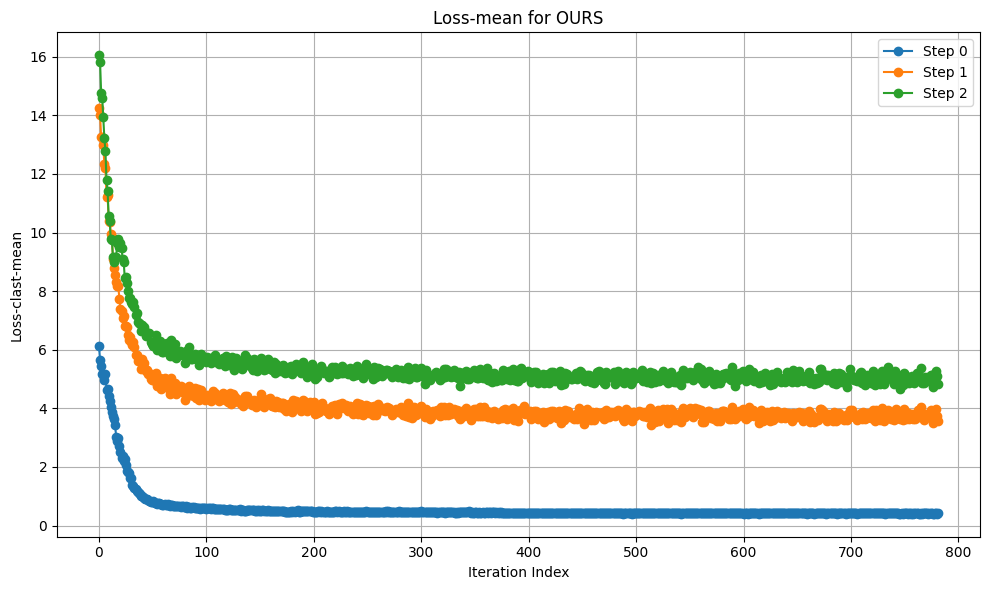

In [5]:
import re
import matplotlib.pyplot as plt

# Load log file
with open(r'/teamspace/studios/this_studio/sfd-main/exps/00000-cifar10-4-3-dpmpp-3-poly7.0/log.txt', 'r') as file:
    log_lines = file.readlines()

# Dictionaries to store loss values per step
loss_by_step = {
    0: [],
    1: [],
    2: []
}

# Extract losses for each step
for line in log_lines:
    match = re.search(r"Step: (\d) \| Loss-clast-mean:\s+([0-9.]+)", line)
    if match:
        step = int(match.group(1))
        loss = float(match.group(2))
        loss_by_step[step].append(loss)

# Plotting
plt.figure(figsize=(10, 6))
for step in sorted(loss_by_step.keys()):
    plt.plot(loss_by_step[step], label=f'Step {step}', marker='o')

plt.title('Loss-mean for OURS weight ')
plt.xlabel('Iteration Index')
plt.ylabel('Loss-clast-mean')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np

def compare_training_logs(original_log_path, our_log_path, branch=1):
    def extract_losses(file_path, loss_type):
        all_losses = []
        with open(file_path, 'r') as f:
            content = f.read()
            for step in range(3):
                if loss_type == 'original':
                    pattern = re.compile(rf"Step:\s*{step}\s*\|\s*Loss-mean:\s*([0-9]+\.[0-9]+)")
                else:
                    pattern = re.compile(rf"Step:\s*{step}\s*\|\s*Loss_ls-{branch}-mean:\s*([0-9]+\.[0-9]+)")
                matches = re.findall(pattern, content)
                all_losses.append([float(m) for m in matches])
        return all_losses

    def calculate_oscillation(losses):
        if len(losses) < 2:
            return {'variance': 0, 'std': 0, 'range': 0, 'mean': 0}
        losses_array = np.array(losses)
        return {
            'variance': np.var(losses_array),
            'std': np.std(losses_array),
            'range': np.max(losses_array) - np.min(losses_array),
            'mean': np.mean(losses_array)
        }

    original_all = extract_losses(original_log_path, 'original')
    our_all = extract_losses(our_log_path, 'ours')
    print("="*150)
    print("For branch  ",branch, " Training")
    print("="*150)
    for step in range(3):
        original_losses = original_all[step]
        our_losses = our_all[step]

        original_metrics = calculate_oscillation(original_losses)
        our_metrics = calculate_oscillation(our_losses)

        # plt.figure(figsize=(12, 6))

        # plt.subplot(1, 2, 1)
        # plt.plot(original_losses, 'b-o', label='Original Method', alpha=0.7)
        # plt.title(f'Original Method - Loss Oscillation (Step {step})')
        # plt.xlabel('Iteration')
        # plt.ylabel('Loss')
        # plt.grid(True, alpha=0.3)
        # plt.legend()

        # plt.subplot(1, 2, 2)
        # plt.plot(our_losses, 'r-o', label='Our Method', alpha=0.7)
        # plt.title(f'Our Method - Loss Oscillation (Step {step})')
        # plt.xlabel('Iteration')
        # plt.ylabel('Loss')
        # plt.grid(True, alpha=0.3)
        # plt.legend()

        # plt.tight_layout()
        # plt.show()

        print("="*60)
        print(f"STEP {step} - TRAINING LOSS OSCILLATION COMPARISON")
        print("="*60)

        print(f"\nOur Method:")
        # print(f"  Mean Loss: {our_metrics['mean']:.4f}")
        # print(f"  Std Dev:   {our_metrics['std']:.4f}")
        # print(f"  Variance:  {our_metrics['variance']:.4f}")
        # print(f"  Range:     {our_metrics['range']:.4f}")
        print(f"  Total Steps: {len(our_losses)}")
        print(f"  Last loss step {step} branch {branch}:  {our_losses[-1] if our_losses else 'N/A'}")
        print(f"  Last loss of original step {step}:  {original_losses[-1] if original_losses else 'N/A'}")

    return {
        'original_losses': original_all,
        'our_losses': our_all,
    }

# teacher 0 [1 2 3] 4 [5 6 7] 8 [9 10 11] 12
# 0 [1 2 3 4] 5 6 7 


In [2]:
results = compare_training_logs('original_training_logs.txt', r'/teamspace/studios/this_studio/sfd-main/exps/00134-cifar10-4-3-dpmpp-3-poly7.0/log.txt',branch=1)
results = compare_training_logs('original_training_logs.txt', r'/teamspace/studios/this_studio/sfd-main/exps/00134-cifar10-4-3-dpmpp-3-poly7.0/log.txt',branch=2)
results = compare_training_logs('original_training_logs.txt', r'/teamspace/studios/this_studio/sfd-main/exps/00134-cifar10-4-3-dpmpp-3-poly7.0/log.txt',branch=3)
results = compare_training_logs('original_training_logs.txt', r'/teamspace/studios/this_studio/sfd-main/exps/00134-cifar10-4-3-dpmpp-3-poly7.0/log.txt',branch=0)


For branch   1  Training
STEP 0 - TRAINING LOSS OSCILLATION COMPARISON

Our Method:
  Total Steps: 782
  Last loss step 0 branch 1:  0.30109838
  Last loss of original step 0:  0.38475537
STEP 1 - TRAINING LOSS OSCILLATION COMPARISON

Our Method:
  Total Steps: 782
  Last loss step 1 branch 1:  1.151793
  Last loss of original step 1:  3.48407173
STEP 2 - TRAINING LOSS OSCILLATION COMPARISON

Our Method:
  Total Steps: 782
  Last loss step 2 branch 1:  4.65574169
  Last loss of original step 2:  4.85880232
For branch   2  Training
STEP 0 - TRAINING LOSS OSCILLATION COMPARISON

Our Method:
  Total Steps: 782
  Last loss step 0 branch 2:  0.31655908
  Last loss of original step 0:  0.38475537
STEP 1 - TRAINING LOSS OSCILLATION COMPARISON

Our Method:
  Total Steps: 782
  Last loss step 1 branch 2:  1.92400157
  Last loss of original step 1:  3.48407173
STEP 2 - TRAINING LOSS OSCILLATION COMPARISON

Our Method:
  Total Steps: 782
  Last loss step 2 branch 2:  4.91851616
  Last loss of ori

In [2]:
import re

def find_min_s2_loss(log_path: str) -> float:

    """
    Parse the log file to extract the last loss values for steps 0, 1, 2
    and return their sum.
    """

    all_losses = [[] for _ in range(3)]

    pattern = re.compile(r"Step:\s*(\d+)\s*\|\s*Loss-mean:\s*([0-9]+\.[0-9]+)")

    with open(log_path, 'r') as f:
        for line in f:
            m = pattern.search(line)
            if m:
                step = int(m.group(1))
                loss = float(m.group(2))
                if 0 <= step < 3:
                    all_losses[step].append(loss)

    step_2_losses=all_losses[-1]

    # print(min(step_2_loss[-400:]))

    return min(step_2_losses)


x=find_min_s2_loss("/teamspace/studios/this_studio/sfd-main/exps/00155-cifar10-4-2-dpmpp-3-poly7.0-afs/log.txt")
print(x)

4.22973728


In [4]:
import re

def find_last_tick(log_path: str) -> int:
    """
    Parse the log file to find the tick value from the last 'tick' line.
    """
    tick_pattern = re.compile(r"tick\s+(\d+)\b")
    last_tick = None

    with open(log_path, 'r') as f:
        for line in f:
            match = tick_pattern.search(line)
            if match:
                last_tick = int(match.group(1))

    return last_tick

# Example usage
log_file = "/teamspace/studios/this_studio/sfd-main/exps/00155-cifar10-4-2-dpmpp-3-poly7.0-afs/log.txt"
print(find_last_tick(log_file))


196


In [7]:
import re

def find_min_s2_loss_ls3(log_path: str) -> float:
    """
    Parse the log file to extract all Step 2 Loss_ls-3-mean values
    and return their minimum.
    """
    
    step2_ls3_losses = []
    
    # Pattern to match Step 2 Loss_ls-3-mean lines
    step2_ls3_pattern = re.compile(r"Step:\s*2\s*\|\s*Loss_ls-3-mean:\s*([0-9]+\.[0-9]+)")
    
    with open(log_path, 'r') as f:
        for line in f:
            match = step2_ls3_pattern.search(line)
            if match:
                loss_value = float(match.group(1))
                step2_ls3_losses.append(loss_value)
                # print(f"Found Step 2 Loss_ls-3-mean: {loss_value}")
    
    if not step2_ls3_losses:
        raise ValueError("No Step 2 Loss_ls-3-mean values found")
    
    min_loss = min(step2_ls3_losses)
    # print(f"\nAll Step 2 Loss_ls-3-mean values: {step2_ls3_losses}")
    # print(f"Total count: {len(step2_ls3_losses)}")
    # print(f"Minimum Step 2 Loss_ls-3-mean: {min_loss}")
    
    return min_loss

# Test with your log file
# x = find_min_s2_loss_ls3("/teamspace/studios/this_studio/sfd-main/training/original_training_logs.txt")
# print(f"Result: {x}")

# Test with your log file
x = find_min_s2_loss_ls3("/teamspace/studios/this_studio/sfd-main/exps/00148-cifar10-4-3-dpmpp-3-poly7.0/log.txt")
print(f"Result: {x}")


Result: 1.93928492


In [56]:
import re

def sum_last_losses(log_path):
    def extract_losses(file_path):
        all_losses = []
        with open(file_path, 'r') as f:
            content = f.read()
            for step in range(3):
                pattern = re.compile(rf"Step:\s*{step}\s*\|\s*Loss-mean:\s*([0-9]+\.[0-9]+)")
                matches = re.findall(pattern, content)
                losses = [float(m) for m in matches]
                all_losses.append(losses)
        return all_losses

    all_losses = extract_losses(log_path)
    last_losses = [step_losses[-1] if step_losses else 0 for step_losses in all_losses]
    total_sum = sum(last_losses)

    print("Last losses for steps 0, 1, 2:", last_losses)
    print("Sum of last losses:", total_sum)
    return total_sum


sum_last_losses(r'/teamspace/studios/this_studio/sfd-main/exps/00134-cifar10-4-3-dpmpp-3-poly7.0/log.txt')

Last losses for steps 0, 1, 2: [1.41737235, 7.81435966, 18.53651047]
Sum of last losses: 27.768242479999998


27.768242479999998